In [67]:
# Entrenando data reducida por PCA y t-SNE

# TODO: Importa las clases que necesites para entrenar los modelos de sklearn
from sklearn.neighbors import KNeighborsClassifier # K Nearest Neigbors
from sklearn.svm import SVC                        # Support Vector Classifier
from sklearn.cluster import KMeans                 # K Means
from matplotlib.colors import ListedColormap

# Encontramos los valores de normalización USANDO LOS DATOS DE ENTRENAMIENTO
scaler = StandardScaler()
scaler.fit(data_train)

def train(X, label, model_type:str):
    # Normalizamos los datos de entrenamiento
    data = scaler.transform(X)

    # TODO: Entrena el modelo y regresa el modelo entrenado en los datos de entrenamiento
    # model puede ser tanto la instancia de la clase que quieras usar, como un string indicando
    if model_type == "knn":
        estimator = KNeighborsClassifier(n_neighbors=3)
    elif model_type == "svm":
        estimator = SVC(kernel='linear') 
    elif model_type == "kmeans":
        estimator = KMeans(n_clusters=len(np.unique(label)))  # Numero de clusters igual al numero de unique labels
    else:
        raise ValueError(f"Modelo no soportado: {model_type}")

    estimator.fit(data, label)
    return estimator

def inference(trained_model, X_val):
    # En inferencia, podemos recibir un solo dato entonces X_val.shape seria (D, )
    # Las clases de sklearn siempre esperan todo en la forma de  N, D
    if X_val.ndim == 1:
        X_val = X_val.reshape(1, -1)

    # TODO: Normaliza los datos de validación
    # El mismos preprocesamiento de datos se aplica a
    # tanto inferencia como entrenamiento
    data = scaler.transform(X_val)

    # TODO: Utiliza el modelo para predecir valores para los datos de validación
    # Regresa las predicciones de tu modelo para X_val
    # En este caso, modelo tiene que ser una instancia de una clase para la cual quieres hacer predicción
    preds = trained_model.predict(data)

    return preds

# Original training models dictionary
trained_models = {
    "knn": None,
    "svm": None,
    "kmeans": None,
}

# Reducing dimensionality using PCA and t-SNE
pca = PCA(n_components=2)
data_train_pca = pca.fit_transform(data_train)

tsne = TSNE(n_components=2)
data_train_tsne = tsne.fit_transform(data_train)

# Dictionaries to store models trained on reduced data
trained_models_pca = {
    "knn_pca": None,
    "svm_pca": None,
    "kmeans_pca": None,
}

trained_models_tsne = {
    "knn_tsne": None,
    "svm_tsne": None,
    "kmeans_tsne": None,
}

# Training models with original data
for model_type in trained_models.keys():
    modelo = train(data_train, target_train, model_type=model_type)
    trained_models[model_type] = modelo

# Training models with PCA reduced data
for model_type in trained_models_pca.keys():
    model_type_original = model_type.replace("_pca", "")
    modelo = train(data_train_pca, target_train, model_type=model_type_original)
    trained_models_pca[model_type] = modelo

# Training models with t-SNE reduced data
for model_type in trained_models_tsne.keys():
    model_type_original = model_type.replace("_tsne", "")
    modelo = train(data_train_tsne, target_train, model_type=model_type_original)
    trained_models_tsne[model_type] = modelo

# Visualization and Evaluation for original data
for name, trained_model in trained_models.items():
    vis_preds(trained_model, data_val, target_val, name)
    evaluate_model(trained_model, data_val, target_val, name)

# Visualization and Evaluation for PCA reduced data
# Note: You might want to reduce data_val using PCA before passing it to vis_preds and evaluate_model
for name, trained_model in trained_models_pca.items():
    vis_preds(trained_model, data_val, target_val, name)
    evaluate_model(trained_model, data_val, target_val, name)

# Visualization and Evaluation for t-SNE reduced data
# Note: You might want to reduce data_val using t-SNE before passing it to vis_preds and evaluate_model
for name, trained_model in trained_models_tsne.items():
    vis_preds(trained_model, data_val, target_val, name)
    evaluate_model(trained_model, data_val, target_val, name)


ValueError: X has 2 features, but StandardScaler is expecting 64 features as input.

# Proyecto 1: Identificando números con imágenes
En este ejercicio analizaras e identificarás números dados en la forma de imagen. Para ello puedes utilizar tu solución preferida identificar grupos de imágenes similares. Por ejemplo, puedes aplicar reducción de dimensionalidad antes o después del entrenamiento, puedes también elegir no usarlo. Para hacer la predicción puedes hacer uso de un método de agrupamiento y resolver la tarea con aprendizaje no supervisado, o puedes utilizar un algoritmo de clasificación y elegir el camino de aprendizaje supervisado.

A diferencia de los ejercicios anteriores donde programaste las soluciones analíticas a los métodos de ML, en este proyecto se recomienda el uso de las funciones y clases integradas de scikit-learn. Para entender el uso de estas clases y ver algunos ejemplos puedes consultar la documentación oficial [sk-learn user guide](https://scikit-learn.org/stable/supervised_learning.html)

En este proyecto tendrás que elegir que método de reducción de dimensionalidad y que método de agrupamiento deseas aplicar a tus datos. Es tu trabajo analizar la información dada para tomar estas decisiones. Lee con atención todas las instrucciones y celdas de código, y recuerda agregar tu código en todas las partes donde veas la instrucción "`TODO`"

## Descripción
Tu trabajo es identificar grupos en imágenes para reconocimiento de números. Para esto, deberás realizar los siguientes pasos:
1. Dado que nuestros datos están en diferentes escalas, es necesario normalizar los datos.
2. Aplicar un método de reducción de dimensionalidad y visualizar los datos
3. Buscar grupos en los datos reducidos con alguna técnica de agrupamiento o clasificación.
4. Interpretar los resultados.
5. Dadas dos imágenes nuevas, identificar a que grupo pertenece. (Inferencia)

Nota como existen múltiples soluciones a este problema. La decisión de como resolverlo es tuya (: intenta hacerlo lo mejor posible!
Comenzamos por importar las librerías correspondientes.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

 ## 1. Analizando los datos
 Comenzamos leyendo nuestros datos y visualizando algunos ejemplos para analizarlos. En este caso utilizaremos el [digits dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html#sphx-glr-auto-examples-datasets-plot-digits-last-image-py). En este dataset encontrarás 1797 imágenes de 8x8. Cada imagen es un dígito escrito a mano. Primero separaremos los datos en entrenamiento y validación

 Recuerda! los datos de entranmiento *son los únicos* que puedes usar para entrenar tus modelos. El conjunto de validación solo se utilizará para evaluar el rendimiento de los modelos que elijas.

In [ ]:
# Cargamos nuestros datos y los separamos en entrenamiento y validación
data, labels = load_digits(return_X_y=True)
data_train, data_val, target_train, target_val = train_test_split(
    data, 
    labels, 
    test_size=0.25
)
print(f"Imágenes en rango {np.max(data)}, {np.min(data)}")

# Entrenamiento
(n_samples, n_features), n_digits = data_train.shape, np.unique(target_train).size
print(f"# Dígitos: {n_digits}; # Muestras de entrenamiento: {n_samples}; # Variables {n_features}")

# Validación
(n_samples, n_features), n_digits = data_val.shape, np.unique(target_val).size
print(f"# Dígitos: {n_digits}; # Muestras de validación: {n_samples}; # Variables {n_features}")

Imágenes en rango 16.0, 0.0
# Dígitos: 10; # Muestras de entrenamiento: 1347; # Variables 64
# Dígitos: 10; # Muestras de validación: 450; # Variables 64


En este ejercicio las imágenes se entregan como un vector de 64 variables, donde cada elemento corresponde al valor de un pixel. Para visualizar los datos en forma de imagen, es necesario transformarlos a la forma adecuada. En las siguiente celda puedes ver algunas imágenes de ejemplo, así como la forma en que podemos transformar el vector de variables a una matriz de 8x8.

<Figure size 640x480 with 0 Axes>

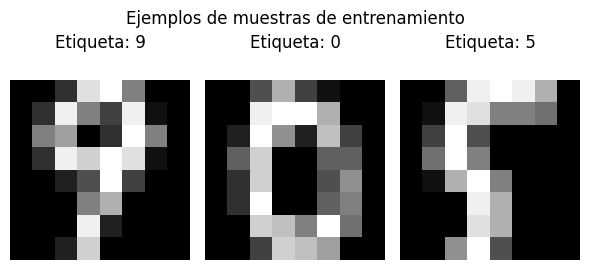

In [ ]:
plt.gray()

# Visualizar algunas imágenes
n_cols = 3
idx = np.random.randint(len(data_train), size=n_cols)
fig, axes = plt.subplots(1, n_cols, figsize=(6,3))
axes = axes.flatten()
for ax, i in zip(axes, idx):
    side = np.sqrt(len(data_train[i])).astype('int')
    # La imagen está dada como un solo vector de longitud 64
    # Cambiamos la forma para tenerla en forma de imagen de 8x8 pixeles
    img = data[i].reshape((side, side))
    ax.matshow(img)
    ax.axis('off')
    ax.set_title(f"Etiqueta: {labels[i]}")
fig.suptitle("Ejemplos de muestras de entrenamiento")
plt.tight_layout()
plt.show()

## Visualización en baja dimensionalidad
En la siguiente celda puedes visualizar como se ven tus datos reduciendo la dimensionalidad de 30 variables a 2. Explora usar TSNE y PCA, y elige el que te de mejor información.

Utiliza las siguientes preguntas para analizar la imgen:
- ¿Cual método de reducción de dimensionalidad funciona mejor en este caso?
- ¿Que puedes deducir de esta imagen?
- ¿Qué representa cada color en este caso?

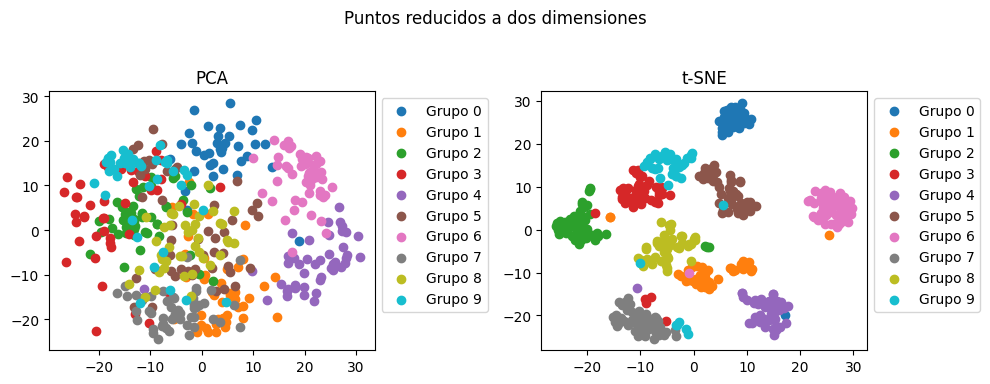

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TODO Reducimos la dimensionalidad de los datos de validacion data_val
# a 2 dimensiones usando TSNE y/o PCA

# Usando PCA
pca = PCA(n_components=2)
reduced_data_pca = pca.fit_transform(data_val)

# Usando t-SNE
tsne = TSNE(n_components=2)
reduced_data_tsne = tsne.fit_transform(data_val)

labels = np.unique(target_train)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle("Puntos reducidos a dos dimensiones")

for c in labels:
    indices = np.where(target_val == c)
    
    # PCA
    plot_data_pca = reduced_data_pca[indices]
    ax[0].scatter(plot_data_pca[:, 0], plot_data_pca[:, 1], label=f"Grupo {c}")
    ax[0].set_title("PCA")
    
    # t-SNE
    plot_data_tsne = reduced_data_tsne[indices]
    ax[1].scatter(plot_data_tsne[:, 0], plot_data_tsne[:, 1], label=f"Grupo {c}")
    ax[1].set_title("t-SNE")

ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# 2. Tu turno - Entrenamiento
Utiliza los datos `data_train` con las etiquetas `target_train` define para entrenar un modelo que identifique dígitos. 
Utiliza las librerías de sklearn para entrenar al menos dos modelos. En esta sección queda a tu criterio:
- Decidir si entrenarás en alta o baja dimensionalidad
- Decidir los modelos que deseas comparar (k-means, reg.logistica, naive bayes, random trees etc.)
- Decidir qué tipo de procesamiento (si alguno) deseas aplicar y por qué

Puedes consultar todos los modelos disponibles de sklear en el [user-guide](https://scikit-learn.org/stable/supervised_learning.html). 

Un método de preprocesamiento de datos muy comun, es normalizar las entradas antes de entrenar el modelo. Considera que si decides hacer esto, deberás normalizar también los datos de validación durante inferencia **DE LA MISMA MANERA** en que normalizaste los datos de entrenamiento. Se recomienda ampliamente el uso de StandardScale para este objetivo.

Considera que **en todo momento** los datos de validación no se usan para encontrar ningún parámetro. Tienes que asumir que no existen hasta el momento que quieras predecir datos usando los modelos que hayas estimado con los datos de entrenamiento.

 ## **<font color=D1A7F2>K-Nearest Neighbors Classifier</font>**

The principle behind nearest neighbor methods is to find a predefined number of training samples closest in distance to the new point, and predict the label from these. The number of samples can be a user-defined constant (k-nearest neighbor learning), or vary based on the local density of points (radius-based neighbor learning). The distance can, in general, be any metric measure: standard Euclidean distance is the most common choice. Neighbors-based methods are known as non-generalizing machine learning methods, since they simply “remember” all of its training data (possibly transformed into a fast indexing structure such as a Ball Tree or KD Tree).

    -scikit learn

## **<font color=D1A7F2>Support Vector Machines (SVM) Classifier</font>** 

As other classifiers, SVC, NuSVC and LinearSVC take as input two arrays: an array X of shape (n_samples, n_features) holding the training samples, and an array y of class labels (strings or integers), of shape (n_samples)

    -scikit learn

## **<font color=D1A7F2>K Means Clustering</font>**

The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares (see below). This algorithm requires the number of clusters to be specified. It scales well to large numbers of samples and has been used across a large range of application areas in many different fields.

    -scikit learn

In [ ]:
# TODO: Importa las clases que necesites para entrenar los modelos de sklearn
from sklearn.neighbors import KNeighborsClassifier # K Nearest Neigbors
from sklearn.svm import SVC                        # Support Vector Classifier
from sklearn.cluster import KMeans                 # K Means
from matplotlib.colors import ListedColormap

# Encontramos los valores de normalización USANDO LOS DATOS DE ENTRENAMIENTO
scaler = StandardScaler()
scaler.fit(data_train)

def train(X, label, model_type:str):
    # Normalizamos los datos de entrenamiento
    data = scaler.transform(X)

    # TODO: Entrena el modelo y regresa el modelo entrenado en los datos de entrenamiento
    # model puede ser tanto la instancia de la clase que quieras usar, como un string indicando
    if model_type == "knn":
        estimator = KNeighborsClassifier(n_neighbors=3)
    elif model_type == "svm":
        estimator = SVC(kernel='linear') 
    elif model_type == "kmeans":
        estimator = KMeans(n_clusters=len(np.unique(label)))  # Numero de clusters igual al numero de unique labels
    else:
        raise ValueError(f"Modelo no soportado: {model_type}")

    estimator.fit(data, label)
    return estimator

def inference(trained_model, X_val):
    # En inferencia, podemos recibir un solo dato entonces X_val.shape seria (D, )
    # Las clases de sklearn siempre esperan todo en la forma de  N, D
    if X_val.ndim == 1:
        X_val = X_val.reshape(1, -1)

    # TODO: Normaliza los datos de validación
    # El mismos preprocesamiento de datos se aplica a
    # tanto inferencia como entrenamiento
    data = scaler.transform(X_val)

    # TODO: Utiliza el modelo para predecir valores para los datos de validación
    # Regresa las predicciones de tu modelo para X_val
    # En este caso, modelo tiene que ser una instancia de una clase para la cual quieres hacer predicción
    preds = trained_model.predict(data)

    return preds

trained_models = {
    "knn": None,
    "svm": None,
    "kmeans": None,
}

for model_type in trained_models.keys():
    modelo = train(data_train, target_train, model_type=model_type)
    trained_models[model_type] = modelo

# 3. Evaluación y análisis de las predicciones
En esta sección incluimos funciones que te permiten visualizar la predicción de tu modelo para el set de validación. Dado que nuestros datos son de alta dimensionalidad (64) necesitamos reducirlos para poder analizar las predicciones. Recuerda que en esta sección solo funcionará si has definido tu modelo correctamente en el método anterior `mi_modelo`.

## 3.1 (Inferencia) Datos de validación en baja dimensionalidad
Completa el código de la siguiente celda para visualizar **las predicciones de TU modelo** de el conjunto de validación en baja dimensionalidad. Utiliza el método de reducción de dimensionalidad que consideres te ayude mejor a analizar tus datos. Cada clase/grupo deberá mostrarse en un color diferente. En base a lo que puedes observar en la imagen, ¿consideras que tu algoritmo ha aprendido algo que tiene sentido?

In [ ]:
def vis_low_dim(data_val, preds, model_type):
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    fig.suptitle(f"Puntos clasificados {model_type} (2 dimensiones)")

    # Buscamos la cantidad de grupos que hay en los datos de validación
    groups = np.unique(preds)
    n_groups = len(groups)
    # Graficamos los datos, con un color diferente para cada clase/grupo
    print(f"Datos {data_val.shape}, predicciones {preds.shape}, clases/grupos {n_groups}")

    # TODO: Reduce los datos de VALIDACIÓN data_val a dos dimensiones para poder visualizarlos
    
    # Usando PCA
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data_val)

    # Usando t-SNE
    tsne = TSNE(n_components=2)
    data_tsne = tsne.fit_transform(data_val)

    for i, reduced_data, title in zip(range(2), [data_pca, data_tsne], ["PCA", "t-SNE"]):
        for g in groups:
            # TODO: Grafica los datos de VALIDACIÓN reducidos (reduced_data.shape = (N, 2))
            # Tal que grafiques aquellos que correspondan al grupo/clase group
            # Investiga plt.scatter, np.where o cómo filtrar arreglos dada una condición booleana
            mask = (preds ==g)
            ax[i].scatter(reduced_data[mask, 0], reduced_data[mask, 1], label=f"Group {g}")
        
        ax[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Datos (450, 64), predicciones (450,), clases/grupos 10


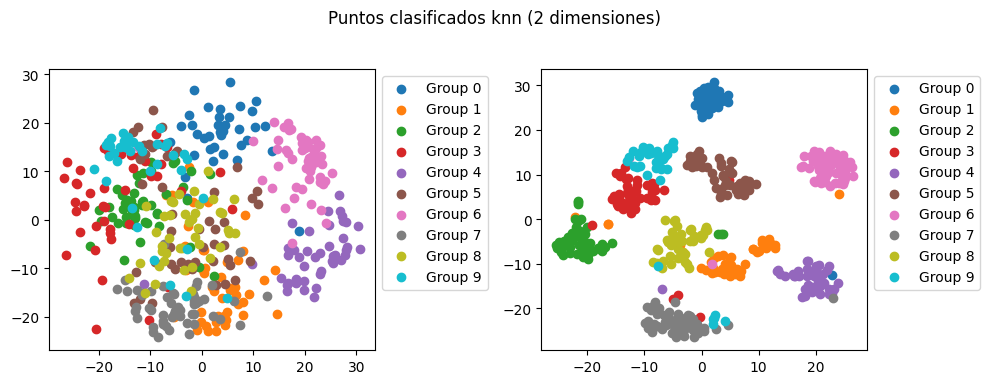

Datos (450, 64), predicciones (450,), clases/grupos 10


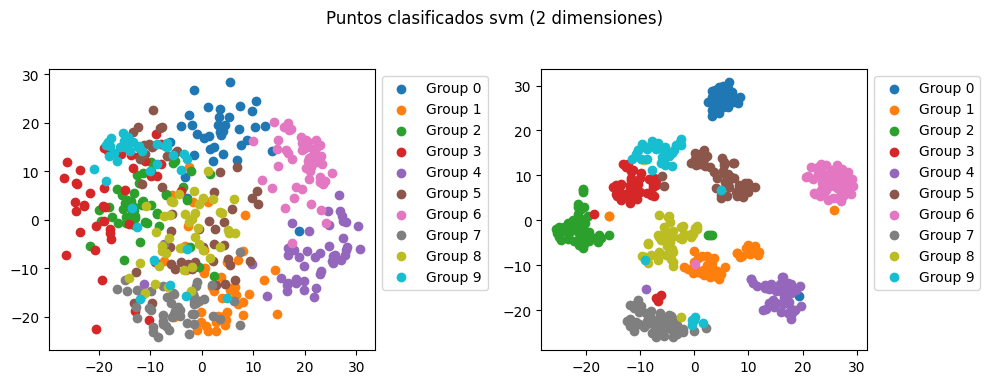

Datos (450, 64), predicciones (450,), clases/grupos 10


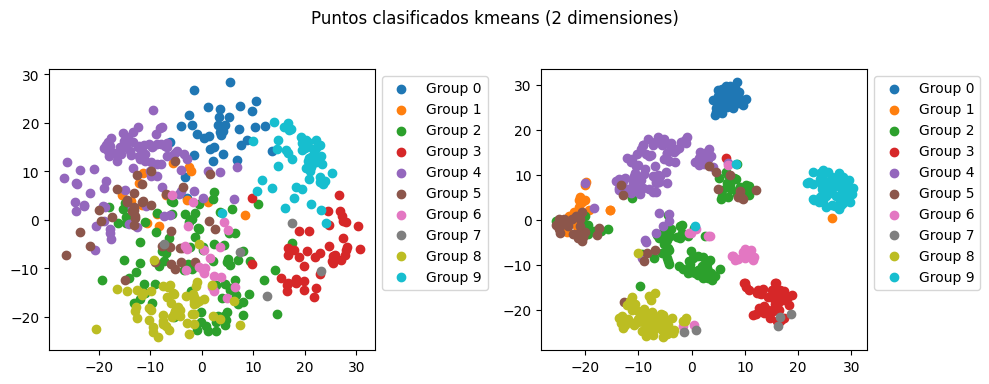

In [ ]:
# Llamamos a inferencia de tu modelo
for model_type, modelo in trained_models.items():
    preds = inference(modelo, data_val)
    vis_low_dim(data_val, preds, model_type)

Analiza la imagen anterior e intenta explicar lo que esta mostrando.
- ¿Que representa cada color en la imagen?
- Dada la imagen, ¿Parece que el modelo entrenado ha aprendido algo con sentido? Explica tu razonamiento.

## 3.2 (Inferencia) Visualizar imagenes en cada grupo/clase
Completa el código de la siguiente celda. El siguiente código llama al método de inferencia anteriormente definido. Deberás mostrar 1 imagen por cada grupo de predicción de tu modelo, intenta seleccionar una imagen representativa del grupo tal que puedas ver que es lo que ha aprendido tu modelo.

#### Métodos de clasificación
Si utilizaste un método de clasificación multiclase, los esperable sería que el valor real de la muestra (GT) sea igual al valor de la predicción para al menos la mayoría de los casos.

#### Métodos de agrupamiento
Si utilizaste un algoritmo de agrupamiento, es esperable que el valor real de la muestra (GT) no sea igual al grupo de tu predicción. Recuerda que al ser aprendizaje no supervisado, necesitamos adicionalmente "mapear" los grupos que haya encontrado el algoritmo a los reales. Puedes usar esta sección para hacer dicho mapeo. Lo mas sencillo es usar un diccionario

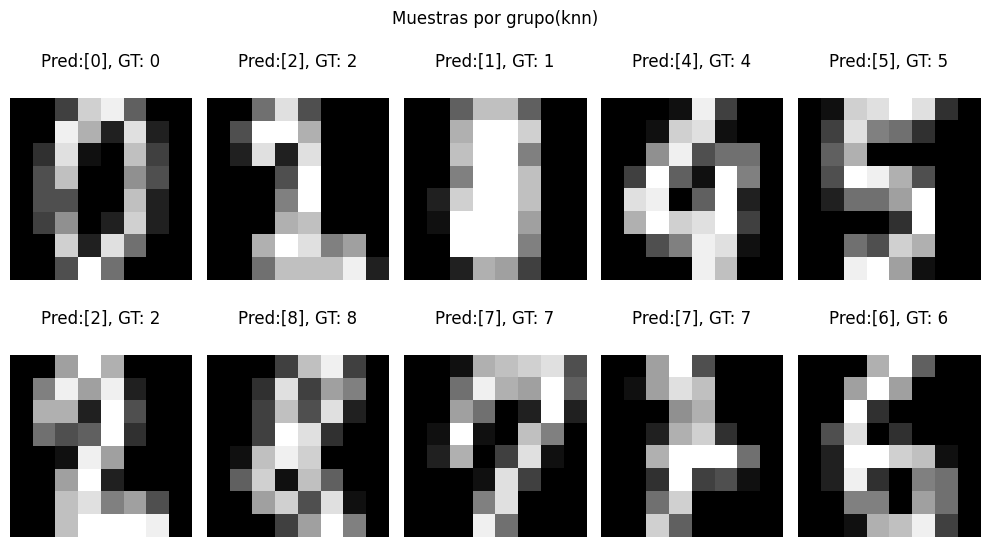

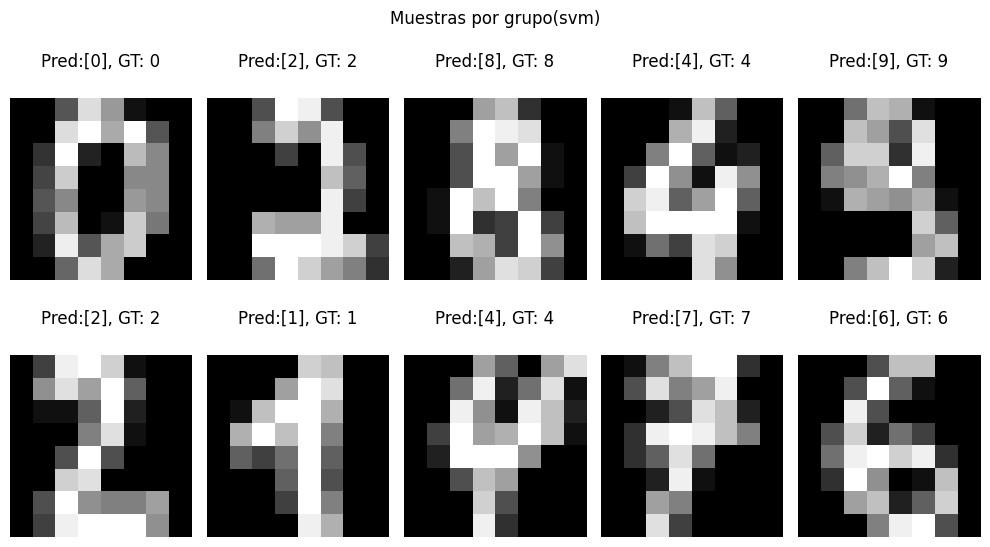

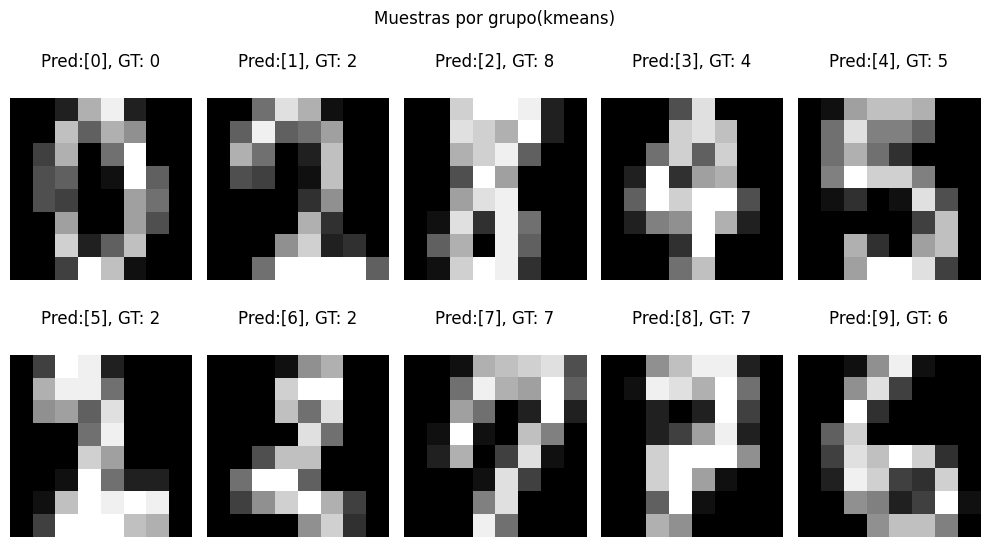

In [ ]:
def vis_preds(trained_model, data_val, target_val, model_name):
    # Llamamos a inferencia de su modelo
    # Este método regresará una cantidad definida de clases
    # Que haya encontrado para los datos de validación
    preds = inference(modelo, data_val)
    group_pred = np.unique(preds)
    n_groups = len(group_pred)

    # Graficar
    n_cols = 5
    fig, axes = plt.subplots(n_groups//n_cols, n_cols, figsize=(10,6))
    axes = axes.flatten()
    for group, ax in zip(group_pred, axes):
        #======================= Start  solution=====================
        # TODO: Filtra data_val para quedarte solamente con aquellos elementos
        # donde la predicción de tu modelo sea igual a group
        # Haz lo mismo para las etiquetas
        mask = (preds == group)
        filtered_data_val = data_val[mask]
        filtered_target_val = target_val[mask]

        # TODO: Selecciona una imagen de los datos en data_val donde pred == group
        # y selecciona la etiqueta real para dicha imagén para mostrarlos juntos
        # Investiga: np.random.randint, np.random.choice etc.
        random_idx = np.random.choice(len(filtered_data_val))
        img_vector = filtered_data_val[random_idx]
        gt = filtered_target_val[random_idx]

        # TODO: Calcula la predicción del modelo para la imagen aleatoria
        # usando el modelo entrenado "trained_model"
        pred = inference(trained_model, img_vector)

        # TODO: La predicción del modelo usa la imagen en forma de vector (1xD)
        # pero para visualizarla tenemos que cambia de forma a una imagen de 8x8 pixeles
        # Cambia la forma de la imagen usando np.reshape a (8, 8)
        img = img_vector.reshape((8, 8))
        
        # TODO: Visualiza la imagen de 8x8 usando ax.matshow Similar al inicio del ejercicio
        # Revisa la documentación de ser necesario
        ax.matshow(img, cmap=plt.cm.gray)

        #======================= end  solution=====================
        ax.set_title(f"Pred:{pred}, GT: {gt}")
        ax.axis('off')
    fig.suptitle(f"Muestras por grupo({model_name})")
    plt.tight_layout()
    plt.show()

for name, trained_model in trained_models.items():
    vis_preds(trained_model, data_val, target_val, name)

## 3.2 (Inferencia) Comparar rendimento de distintos modelos
En esta sección evalúa tus dos modelos entrenados en el conjunto de validación utilizando alguna métrica vista en clase (accuracy, F1, Precision, Recall etc.) y determina cuantitativamente cual funciona mejor. Investiga como usar las métricas de sklearn en la sección de [Classification metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)

In [ ]:
from sklearn import metrics

# TODO: Para todos los modelos que entrenaste, calcula un valor 
# que indique la calidad de las predicciones en los datos de validación
# utiliza: data_val y target_val
for name, trained_model in trained_models.items():
    # Calcula la predicción y evalúa la calidad de predicción vs. las etiquetas reales (target_val)
    preds = inference(trained_model, data_val) 
    score = metrics.accuracy_score(target_val, preds) 
    print(f"Modelo {name}: {score:.4f}")


Modelo knn: 0.9778
Modelo svm: 0.9844
Modelo kmeans: 0.1356


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# TODO: Para todos los modelos que entrenaste, calcula un valor 
# que indique la calidad de las predicciones en los datos de validación
# utiliza: data_val y target_val

def evaluate_model(trained_model, data_val, target_val, model_name):
    # predicciones
    preds = inference(trained_model, data_val)
    
    accuracy = accuracy_score(target_val, preds)
    precision = precision_score(target_val, preds, average='weighted')
    recall = recall_score(target_val, preds, average='weighted')
    f1 = f1_score(target_val, preds, average='weighted')
    
    print(f"Metrics for {model_name}:")
    print(f"Accuracy score: {accuracy:.4f}")
    print(f"Precision score: {precision:.4f}")
    print(f"Recall score: {recall:.4f}")
    print(f"F1 Score score: {f1:.4f}")


for name, trained_model in trained_models.items():
# Calcula la predicción y evalúa la calidad de predicción vs. las etiquetas reales (target_val)

    evaluate_model(trained_model, data_val, target_val, name)
    print(f"\n")

Metrics for knn:
Accuracy score: 0.9778
Precision score: 0.9782
Recall score: 0.9778
F1 Score score: 0.9777


Metrics for svm:
Accuracy score: 0.9844
Precision score: 0.9847
Recall score: 0.9844
F1 Score score: 0.9844


Metrics for kmeans:
Accuracy score: 0.1356
Precision score: 0.1641
Recall score: 0.1356
F1 Score score: 0.1365




En base al análisis tanto cualitativo como cuantitativo, discute en tu blog cual modelo funciona mejor justificando tu razonamiento. Puedes usar las siguientes preguntas como guía según las decisiones que hayas tomado:
- ¿Funcionó mejor entrenar en alta o baja dimensionalidad?
- ¿Funcionó mejor usar un método de aprendizaje supervisado o no supervisado?
- ¿Probaste algún método de preprocesamiento distinto?
- ¿Funcionó mejor usar imágenes normalizadas o no normalizadas?